In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# import VGG 19 model and keras Model API
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model




In [9]:
pwd


'C:\\Users\\Dell\\jupyter_project'

In [7]:
content_path = "shinjiprofil.jpg"
style_path = "FLORAL_1400x.jpg" 

In [8]:

# code
# this function download the VGG model and initialise it
model = VGG19(
    include_top=False,
    weights='imagenet'
)
# set training to False
model.trainable = False
# Print details of different layers
 
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [9]:

def load_and_process_image(image_path):
    img = load_img(image_path)
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img


In [10]:
# code
def deprocess(img):

    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]

    img = np.clip(img, 0, 255).astype('uint8')
    return img


def display_image(image):
    if len(image.shape) == 4:
        img = np.squeeze(image, axis=0)

    img = deprocess(img)

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return


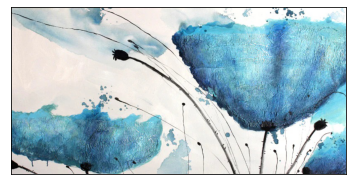

In [15]:

content_img = load_and_process_image(content_path)
display_image(content_img)


style_img = load_and_process_image(style_path)
display_image(style_img)


In [12]:
#probe the output layer
content_layer = 'block5_conv2'
content_model = Model(
    inputs=model.input,
    outputs=model.get_layer(content_layer).output
)
content_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [16]:

style_layers = [
    'block1_conv1',
    'block3_conv1',
    'block5_conv1'
]
style_models = [Model(inputs=model.input,
                    outputs=model.get_layer(layer).output) for layer in style_layers]


In [17]:

def content_cost(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    loss = tf.reduce_mean(tf.square(a_C - a_G))
    return loss


In [18]:
# gram matrix
def gram_matrix(A):
    channels = int(A.shape[-1])
    a = tf.reshape(A, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)


weight_of_layer = 1. / len(style_models)



def style_cost(style, generated):
    J_style = 0

    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        current_cost = tf.reduce_mean(tf.square(GS - GG))
        J_style += current_cost * weight_of_layer

    return J_style


In [21]:
# training function
generated_images = []
epochs = []
loss = []

def training_loop(content_path, style_path, iterations=50, a=10, b=1000):
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    generated = tf.Variable(content, dtype=tf.float32)

    opt = tf.keras.optimizers.Adam(learning_rate=7)

    best_cost = float('inf')
    best_image = None
    for i in range(iterations):
        %time
        with tf.GradientTape() as tape:
            J_content = content_cost(content, generated)
            J_style = style_cost(style, generated)
            J_total = a * J_content + b * J_style

        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])

        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()

        print("Iteration :{}".format(i))
        epochs.append(i)
        print('Total Loss {:e}.'.format(J_total))
        loss.append(J_total)
        generated_images.append(generated.numpy())

    return best_image


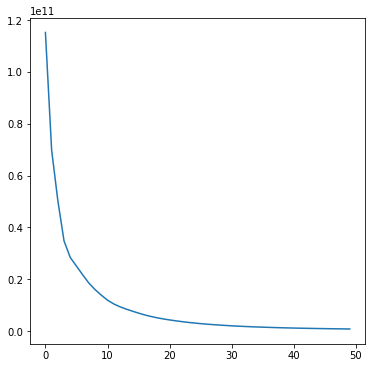

In [23]:
plt.figure(figsize=(6,6))
plt.plot(epochs,loss)

In [22]:
final_img = training_loop(content_path, style_path)

Wall time: 0 ns
Iteration :0
Total Loss 1.152179e+11.
Wall time: 1 ms
Iteration :1
Total Loss 6.984865e+10.
Wall time: 1 ms
Iteration :2
Total Loss 5.031231e+10.
Wall time: 1 ms
Iteration :3
Total Loss 3.474910e+10.
Wall time: 0 ns
Iteration :4
Total Loss 2.840056e+10.
Wall time: 1 ms
Iteration :5
Total Loss 2.506901e+10.
Wall time: 1e+03 µs
Iteration :6
Total Loss 2.171727e+10.
Wall time: 0 ns
Iteration :7
Total Loss 1.851491e+10.
Wall time: 0 ns
Iteration :8
Total Loss 1.599739e+10.
Wall time: 1e+03 µs
Iteration :9
Total Loss 1.385627e+10.
Wall time: 993 µs
Iteration :10
Total Loss 1.193191e+10.
Wall time: 0 ns
Iteration :11
Total Loss 1.047334e+10.
Wall time: 0 ns
Iteration :12
Total Loss 9.383786e+09.
Wall time: 1 ms
Iteration :13
Total Loss 8.491145e+09.
Wall time: 0 ns
Iteration :14
Total Loss 7.696642e+09.
Wall time: 999 µs
Iteration :15
Total Loss 6.923699e+09.
Wall time: 1 ms
Iteration :16
Total Loss 6.231098e+09.
Wall time: 1 ms
Iteration :17
Total Loss 5.636208e+09.
Wall tim

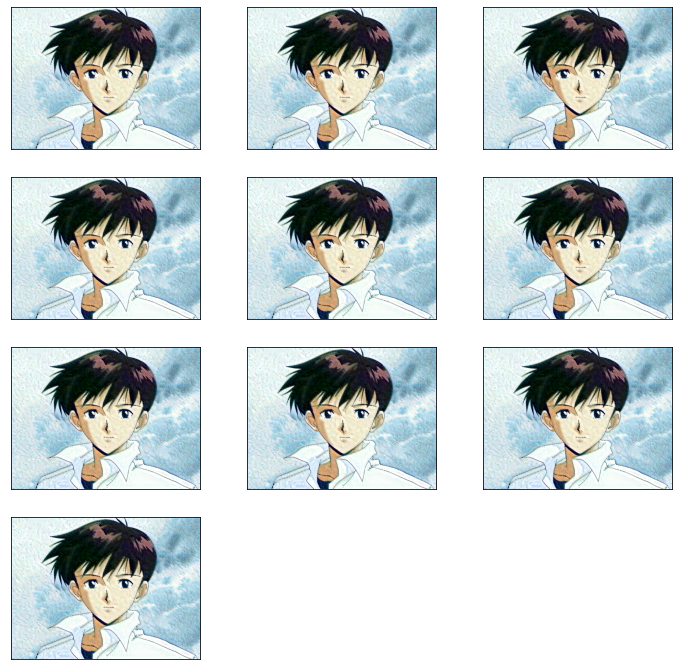

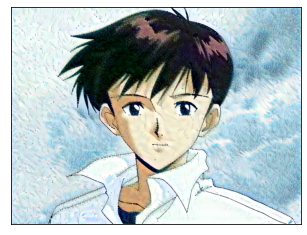

In [24]:
# code to display best generated image and last 10 intermediate results
plt.figure(figsize=(12, 12))

for i in range(10):
    plt.subplot(4, 3, i + 1)
    display_image(generated_images[i+39])
plt.show()

# plot best result
display_image(final_img)
